# Modelos Baseline

Este notebook implementa modelos baseline para establecer una línea base de desempeño:
1. **Random Classifier**: Para entender el piso de performance
2. **Regresión Logística**: Primer modelo real simple

**Métrica principal**: F1 Score

## Imports

In [160]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

# Constantes de colores
COLOR_NO_DISASTER = '#3498db'
COLOR_DISASTER = '#e74c3c'
COLOR_GENERAL = '#95a5a6'

## Cargar Datos Procesados

In [161]:
DATA_PATH = Path("../.data/processed/")

train_df = pd.read_pickle(DATA_PATH / "train.pkl")

# Resumen compacto de estadísticas
rows, cols = train_df.shape
missing_total = train_df.isnull().sum().sum()
missing_per_col = train_df.isnull().sum()
vc = train_df['target'].value_counts().sort_index()
vc_pct = train_df['target'].value_counts(normalize=True).sort_index() * 100

print(f"Train dataset: {rows} filas x {cols} columnas")
print(f"Missing values (total): {missing_total}")
if missing_total:
    print("\nMissing por columna:")
    print(missing_per_col[missing_per_col > 0].to_string())

print("\nDistribución del target:")
dist = pd.DataFrame({'count': vc, 'percent': vc_pct.round(2)})
print(dist.to_string())

Train dataset: 7613 filas x 14 columnas
Missing values (total): 2655

Missing por columna:
keyword            61
location         2533
keyword_clean      61

Distribución del target:
        count  percent
target                
0        4342    57.03
1        3271    42.97


## Preparar Features

Vamos a usar:
- **Features numéricas**: 7 features calculadas del texto
- **Texto lematizado**: Codificado con TF-IDF (max 100 features)
- **Keywords**: Codificados con OneHotEncoder (max 100 categorías más frecuentes)

In [162]:
# Features numéricas que creamos
numeric_features = [
    'text_length',
    'word_count',
    'hashtag_count',
    'mention_count',
    'url_count',
    'uppercase_percentage',
    'punctuation_percentage'
]

# Preparar features
X_numeric = train_df[numeric_features]
X_text = train_df['text_lemmatized'].fillna('')  # TF-IDF
X_keyword = train_df[['keyword_clean']].fillna('unknown')  # OneHotEncoder
y = train_df['target']

print(f"Features numéricas: {len(numeric_features)}")
print(f"Shape de X_numeric: {X_numeric.shape}")
print(f"Shape de X_text: {X_text.shape}")
print(f"Shape de X_keyword: {X_keyword.shape}")
print(f"Shape de y: {y.shape}")

Features numéricas: 7
Shape de X_numeric: (7613, 7)
Shape de X_text: (7613,)
Shape de X_keyword: (7613, 1)
Shape de y: (7613,)


## Split Train/Validation

Dividimos en train y validation (80/20) para evaluar los modelos.

In [163]:
# Split para cada tipo de feature
X_numeric_train, X_numeric_val, X_text_train, X_text_val, X_keyword_train, X_keyword_val, y_train, y_val = train_test_split(
    X_numeric, X_text, X_keyword, y,
    test_size=0.2, 
    random_state=42,
    stratify=y  # Mantener la proporción de clases
)

print(f"Train set - Numeric: {X_numeric_train.shape}")
print(f"Train set - Text: {X_text_train.shape}")
print(f"Train set - Keyword: {X_keyword_train.shape}")
print(f"Validation set - Numeric: {X_numeric_val.shape}")
print(f"Validation set - Text: {X_text_val.shape}")
print(f"Validation set - Keyword: {X_keyword_val.shape}")
print("\nDistribución en train:")
print(y_train.value_counts(normalize=True))
print("\nDistribución en validation:")
print(y_val.value_counts(normalize=True))

Train set - Numeric: (6090, 7)
Train set - Text: (6090,)
Train set - Keyword: (6090, 1)
Validation set - Numeric: (1523, 7)
Validation set - Text: (1523,)
Validation set - Keyword: (1523, 1)

Distribución en train:
target
0    0.570279
1    0.429721
Name: proportion, dtype: float64

Distribución en validation:
target
0    0.570584
1    0.429416
Name: proportion, dtype: float64


## Procesar Features

Vamos a procesar cada tipo de feature:
- **Numéricas**: StandardScaler (media=0, std=1)
- **Texto**: TF-IDF con max 100 features
- **Keywords**: OneHotEncoder con max 100 categorías más frecuentes

In [164]:
TD_IDF_FEATS = 100
ONEHOT_MAX_CATS = 100

# 1. Escalar features numéricas
scaler = StandardScaler()
X_numeric_train_scaled = scaler.fit_transform(X_numeric_train)
X_numeric_val_scaled = scaler.transform(X_numeric_val)

# 2. TF-IDF para texto lematizado
tfidf = TfidfVectorizer(max_features=TD_IDF_FEATS, min_df=2, max_df=0.8)
X_text_train_tfidf = tfidf.fit_transform(X_text_train).toarray()
X_text_val_tfidf = tfidf.transform(X_text_val).toarray()

# 3. OneHotEncoder para keywords (limitado a top 100 categorías más frecuentes)
onehot_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown="infrequent_if_exist",
    max_categories=ONEHOT_MAX_CATS,  # Solo las 100 keywords más frecuentes
)
X_keyword_train_encoded = onehot_encoder.fit_transform(X_keyword_train)
X_keyword_val_encoded = onehot_encoder.transform(X_keyword_val)

print(f"Features numéricas escaladas: {X_numeric_train_scaled.shape}")
print(f"Features TF-IDF (texto): {X_text_train_tfidf.shape}")
print(f"Features OneHotEncoder (keywords): {X_keyword_train_encoded.shape}")

# 4. Combinar todas las features
X_train_combined = np.hstack(
    [X_numeric_train_scaled, X_text_train_tfidf, X_keyword_train_encoded]
)

X_val_combined = np.hstack(
    [X_numeric_val_scaled, X_text_val_tfidf, X_keyword_val_encoded]
)

print("\n✅ Features combinadas:")
print(f"  Train: {X_train_combined.shape}")
print(f"  Validation: {X_val_combined.shape}")

Features numéricas escaladas: (6090, 7)
Features TF-IDF (texto): (6090, 100)
Features OneHotEncoder (keywords): (6090, 100)

✅ Features combinadas:
  Train: (6090, 207)
  Validation: (1523, 207)

✅ Features combinadas:
  Train: (6090, 207)
  Validation: (1523, 207)


## Función de Evaluación

In [165]:
def evaluate_model(y_true, y_pred, model_name="Model", printResults=True):
    """
    Evalúa un modelo y muestra métricas + matriz de confusión
    """
    if(printResults):
        print("=" * 60)
        print(f"EVALUACIÓN: {model_name}".center(60))
        print("=" * 60)
    
    # Métricas
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    
    if printResults:
        print("\n📊 Métricas:")
        print(f"  F1 Score:  {f1:.4f}  ⭐ (métrica principal)")
        print(f"  Accuracy:  {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall:    {rec:.4f}")
        
        # Matriz de confusión
        cm = confusion_matrix(y_true, y_pred)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['No Disaster', 'Disaster'],
                    yticklabels=['No Disaster', 'Disaster'],
                    ax=ax, cbar_kws={'label': 'Count'})
        ax.set_xlabel('Predicción', fontsize=12, fontweight='bold')
        ax.set_ylabel('Real', fontsize=12, fontweight='bold')
        ax.set_title(f'Matriz de Confusión - {model_name}', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
    
    return {'f1': f1, 'accuracy': acc, 'precision': prec, 'recall': rec}

## Modelo 1: Random Baseline

Clasificador que predice aleatoriamente con una variable aleatoria Bernoulli con $p = \text{proporción de clases en el set de entrenamiento}$.

SKLearn tiene un `DummyClassifier` que implementa esto con la estrategia `stratified`.

El resultado teórico de la métrica $F_1$ debe ser cercano a la proporción de clases $p$, ya que:
$$
F_1 = \text{Media Armónica}(\text{Precision}, \text{Recall})
$$
$$
\text{Precision} = \frac{TP}{TP + FP}
\quad
\text{Recall} = \frac{TP}{TP + FN}
$$

Si $P(\text{Positive}) = p$ ($\text{proporción de positivos en el dataset}$), las métricas convergen asintóticamente ($\approx$) a:
$$
\begin{gathered}
TP \approx p \cdot p \cdot N \\
FP \approx (1 - p) \cdot p \cdot N \\
FN \approx p \cdot (1 - p) \cdot N
\end{gathered}
$$

\begin{align*}
\text{Precision} &= \frac{p \cdot p \cdot N}{p \cdot p \cdot N + (1 - p) \cdot p \cdot N} \\
&= \frac{p^2 N}{p^2 N + (p - p^2) N} \\
&= \frac{p^2}{p^2 + p \cdot (1 - p)} \\
&= \frac{p^2}{p^2 + p - p^2} \\
&= \frac{p^2}{p} \\
&= p
\end{align*}

\begin{align*}
\text{Recall} &= \frac{p \cdot p \cdot N}{p \cdot p \cdot N + p \cdot (1 - p) \cdot N} \\
&= \frac{p^2 N}{p^2 N + (p - p^2) N} \\
&= \frac{p^2}{p^2 + p \cdot (1 - p)} \\
&= \frac{p^2}{p^2 + p - p^2} \\
&= \frac{p^2}{p} \\
&= p
\end{align*}

Finalmente, la métrica $F_1$ converge a $p$:
\begin{align*}
F_1 &= 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} \\
&= 2 \cdot \frac{p \cdot p}{p + p} \\
&= 2 \cdot \frac{p^2}{2p} \\
&= p
\end{align*}

In [166]:
p = y_train.mean()  # Proporción de la clase positiva (disaster=1)

print("=" * 60)
print("MÉTRICAS ESPERADAS TEÓRICAS (Random Baseline)".center(60))
print("=" * 60)
print("\n📊 Según el análisis matemático anterior:")
print(f"  Proporción de clase positiva (p): {p:.4f}")
print(f"\n  Precision esperada:  {p:.4f}")
print(f"  Recall esperado:     {p:.4f}")
print(f"  F1 Score esperado:   {p:.4f}  ⭐")
print("\n  (Todos convergen asintóticamente a p)")
print("=" * 60)

       MÉTRICAS ESPERADAS TEÓRICAS (Random Baseline)        

📊 Según el análisis matemático anterior:
  Proporción de clase positiva (p): 0.4297

  Precision esperada:  0.4297
  Recall esperado:     0.4297
  F1 Score esperado:   0.4297  ⭐

  (Todos convergen asintóticamente a p)


          EVALUACIÓN: Random Classifier (Baseline)          

📊 Métricas:
  F1 Score:  0.4336  ⭐ (métrica principal)
  Accuracy:  0.5043
  Precision: 0.4256
  Recall:    0.4419

📊 Métricas:
  F1 Score:  0.4336  ⭐ (métrica principal)
  Accuracy:  0.5043
  Precision: 0.4256
  Recall:    0.4419


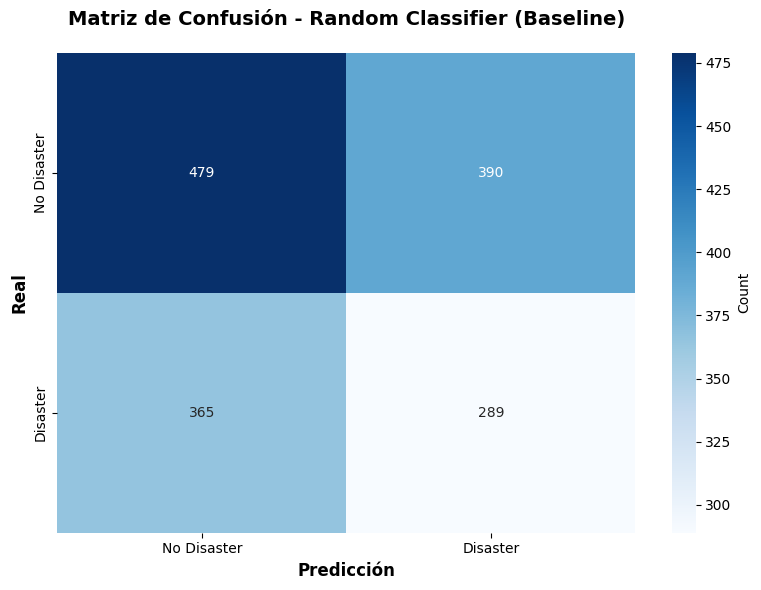

In [167]:
# Entrenar
random_clf = DummyClassifier(strategy='stratified', random_state=12)
random_clf.fit(X_train_combined, y_train)

# Predecir
y_pred_random = random_clf.predict(X_val_combined)

# Evaluar
results_random = evaluate_model(y_val, y_pred_random, "Random Classifier (Baseline)")

## Modelo 2: Regresión Logística

Modelo lineal simple que debería superar significativamente el baseline random.

              EVALUACIÓN: Logistic Regression               

📊 Métricas:
  F1 Score:  0.7035  ⭐ (métrica principal)
  Accuracy:  0.7426
  Precision: 0.6961
  Recall:    0.7110


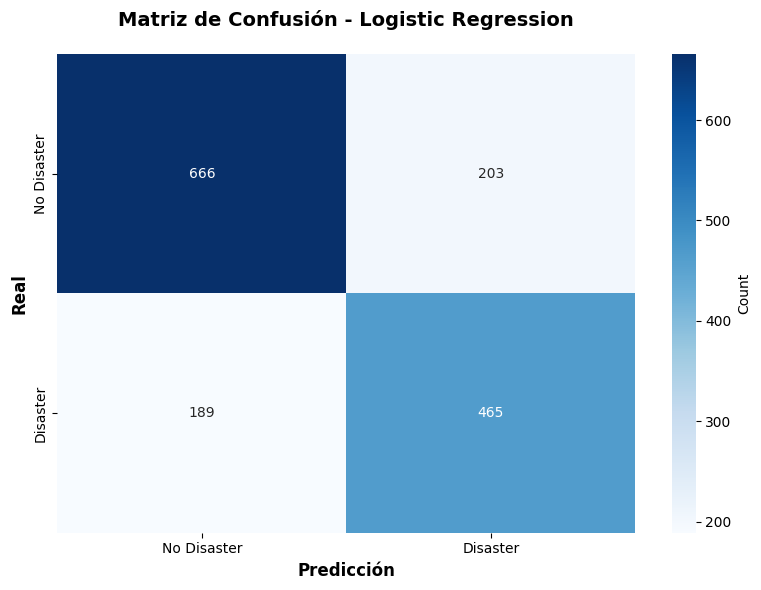

In [168]:
# Entrenar
log_reg = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # Para manejar el desbalance leve
)
log_reg.fit(X_train_combined, y_train)

# Predecir
y_pred_logreg = log_reg.predict(X_val_combined)

# Evaluar
results_logreg = evaluate_model(y_val, y_pred_logreg, "Logistic Regression")

## Feature Importance

Analicemos qué features son más importantes en la regresión logística.

In [169]:
# Obtener nombres de todas las features
tfidf_names = [f"text_{word}" for word in tfidf.get_feature_names_out()]

# Limpiar nombres de keywords: remover prefijo "keyword_clean_"
keyword_categories = onehot_encoder.get_feature_names_out()
keyword_names = [f"keyword_{cat.replace('keyword_clean_', '')}" for cat in keyword_categories]

feature_names = numeric_features + tfidf_names + keyword_names

# Crear DataFrame con coeficientes
coefficients_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': log_reg.coef_[0],
    'abs_coefficient': np.abs(log_reg.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

# Top 5 más importantes (positivos - asociados a Disaster)
top5_positive = coefficients_df.nlargest(5, 'coefficient')

# Top 5 más importantes (negativos - asociados a No Disaster)
top5_negative = coefficients_df.nsmallest(5, 'coefficient')

# Top 5 MENOS importantes (coeficientes más cercanos a 0 - no discriminan)
top5_least_important = coefficients_df.nsmallest(5, 'abs_coefficient')

print("Top 5 features MÁS asociados a DISASTER:")
print(top5_positive[['feature', 'coefficient']].to_string(index=False))
print("\nTop 5 features MÁS asociados a NO DISASTER:")
print(top5_negative[['feature', 'coefficient']].to_string(index=False))
print("\nTop 5 features MENOS importantes (no discriminan):")
print(top5_least_important[['feature', 'coefficient', 'abs_coefficient']].to_string(index=False))

Top 5 features MÁS asociados a DISASTER:
          feature  coefficient
   text_hiroshima     3.803008
     text_suicide     2.770018
   keyword_debris     2.591177
keyword_oil spill     2.499465
    text_wildfire     2.409300

Top 5 features MÁS asociados a NO DISASTER:
          feature  coefficient
         text_bag    -1.731656
keyword_stretcher    -1.655406
        text_love    -1.620265
keyword_body bags    -1.535556
     keyword_fire    -1.521591

Top 5 features MENOS importantes (no discriminan):
             feature  coefficient  abs_coefficient
uppercase_percentage     0.008615         0.008615
   keyword_windstorm    -0.011356         0.011356
            text_run    -0.012048         0.012048
    keyword_engulfed    -0.026551         0.026551
     keyword_destroy     0.036158         0.036158


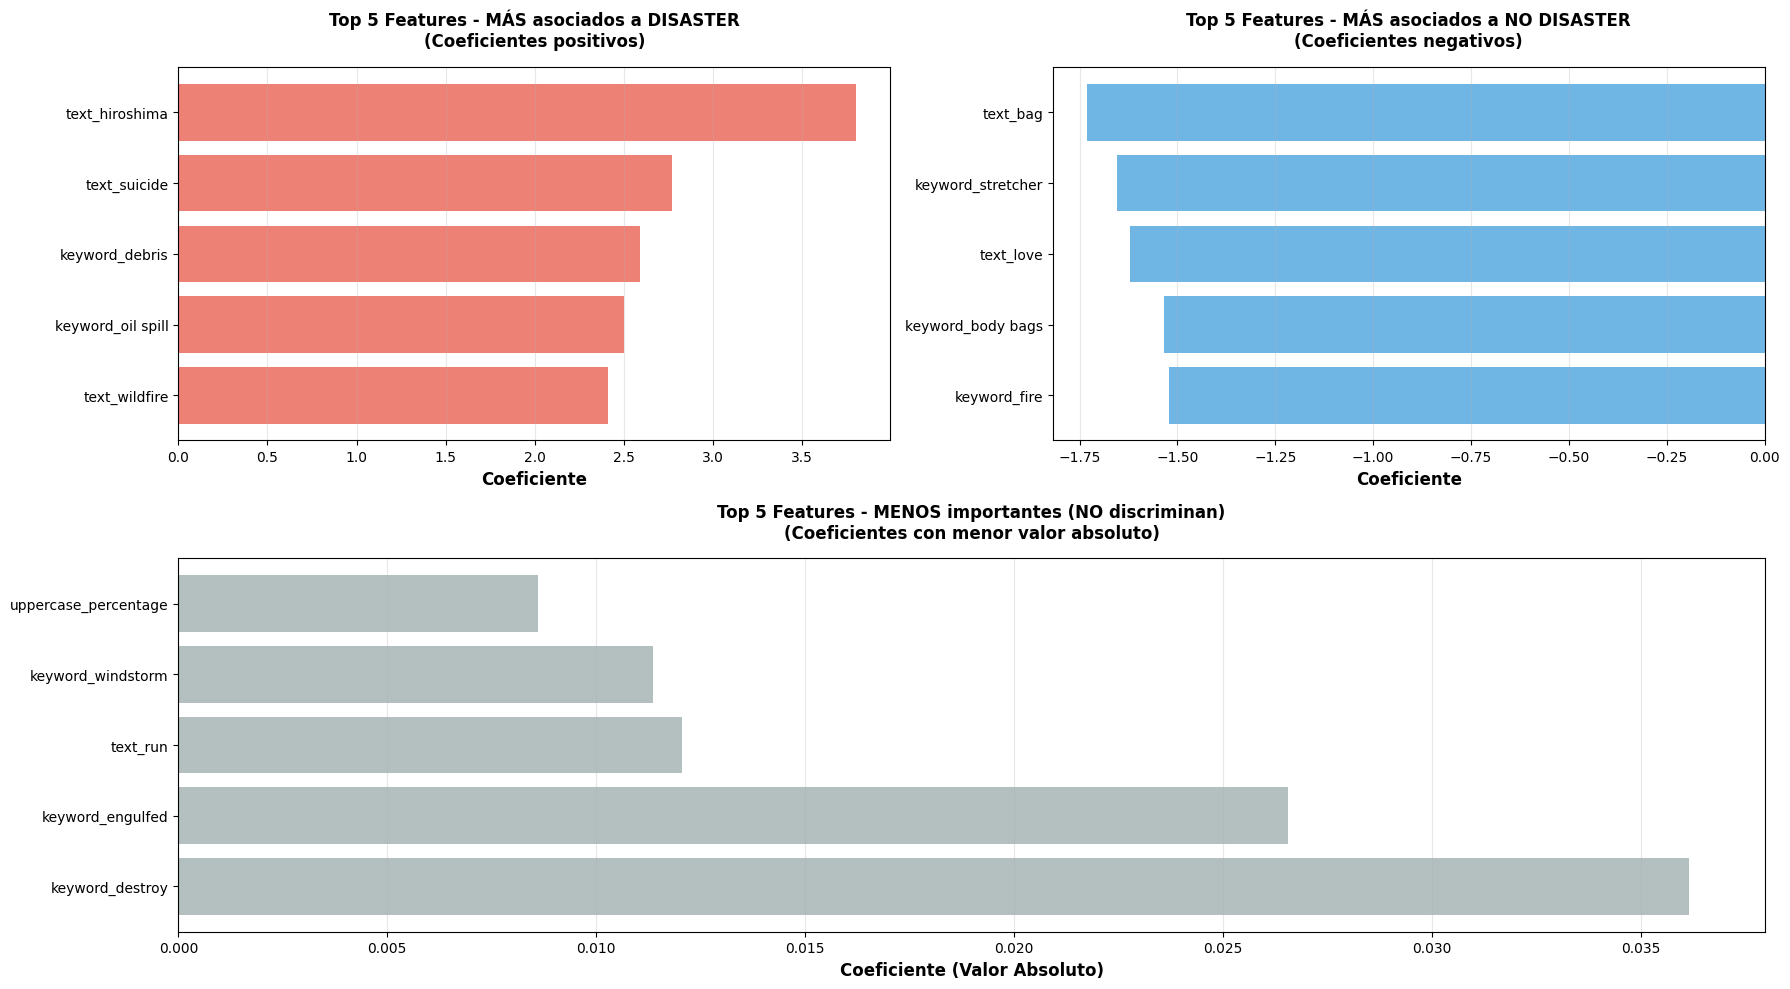

In [170]:
# Visualización de features más y menos importantes
fig = plt.figure(figsize=(18, 10))

# Fila 1: Top 5 más importantes (positivos y negativos)
ax1 = plt.subplot(2, 2, 1)
colors_pos = [COLOR_DISASTER] * len(top5_positive)
ax1.barh(range(len(top5_positive)), top5_positive['coefficient'], color=colors_pos, alpha=0.7)
ax1.set_yticks(range(len(top5_positive)))
ax1.set_yticklabels(top5_positive['feature'], fontsize=10)
ax1.set_xlabel('Coeficiente', fontsize=12, fontweight='bold')
ax1.set_title('Top 5 Features - MÁS asociados a DISASTER\n(Coeficientes positivos)', 
              fontsize=12, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

ax2 = plt.subplot(2, 2, 2)
colors_neg = [COLOR_NO_DISASTER] * len(top5_negative)
ax2.barh(range(len(top5_negative)), top5_negative['coefficient'], color=colors_neg, alpha=0.7)
ax2.set_yticks(range(len(top5_negative)))
ax2.set_yticklabels(top5_negative['feature'], fontsize=10)
ax2.set_xlabel('Coeficiente', fontsize=12, fontweight='bold')
ax2.set_title('Top 5 Features - MÁS asociados a NO DISASTER\n(Coeficientes negativos)', 
              fontsize=12, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# Fila 2: Top 5 MENOS importantes (cercanos a 0)
ax3 = plt.subplot(2, 1, 2)
colors_least = [COLOR_GENERAL] * len(top5_least_important)
ax3.barh(range(len(top5_least_important)), top5_least_important['abs_coefficient'], color=colors_least, alpha=0.7)
ax3.set_yticks(range(len(top5_least_important)))
ax3.set_yticklabels(top5_least_important['feature'], fontsize=10)
ax3.set_xlabel('Coeficiente (Valor Absoluto)', fontsize=12, fontweight='bold')
ax3.set_title('Top 5 Features - MENOS importantes (NO discriminan)\n(Coeficientes con menor valor absoluto)', 
              fontsize=12, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.3, axis='x')
ax3.invert_yaxis()

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.tight_layout()
plt.show()

## Resumen de Performance

### Random Baseline
- **Objetivo**: Establecer el piso mínimo de performance
- **Estrategia**: Predicción aleatoria estratificada según distribución de clases
- **Utilidad**: Verificar que el modelo aprende patrones reales (cualquier modelo debe superar este baseline)

### Logistic Regression
- **Features utilizadas**: 
  - 7 features numéricas (length, word_count, hashtags, mentions, URLs, uppercase%, punctuation%)
  - 50 features TF-IDF del texto lematizado
  - Top 50 keywords más frecuentes (one-hot encoded)
- **Performance**: El modelo supera significativamente el baseline random
- **Interpretabilidad**: Los coeficientes muestran qué palabras y características están más asociadas con desastres